In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis, LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Analyze Data


Data shape (569, 31)


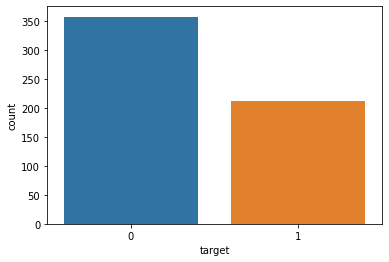

In [ ]:
data = pd.read_csv("data.csv")
data.drop(["id"], inplace = True, axis = 1)

data["diagnosis"] = [1 if i.strip() == "M" else 0 for i in data.diagnosis]
data = data.rename(columns = {"diagnosis":"target"})

sns.countplot(data["target"])
print("\nData shape", data.shape)
describeData = data.describe().T

In [ ]:
data.head()

,target,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
target,569.0,0.372583,0.483918,0.000000,0.000000,0.000000,1.000000,1.00000
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400


In [ ]:
data.isnull().sum().any()

False

# Correlation matrix

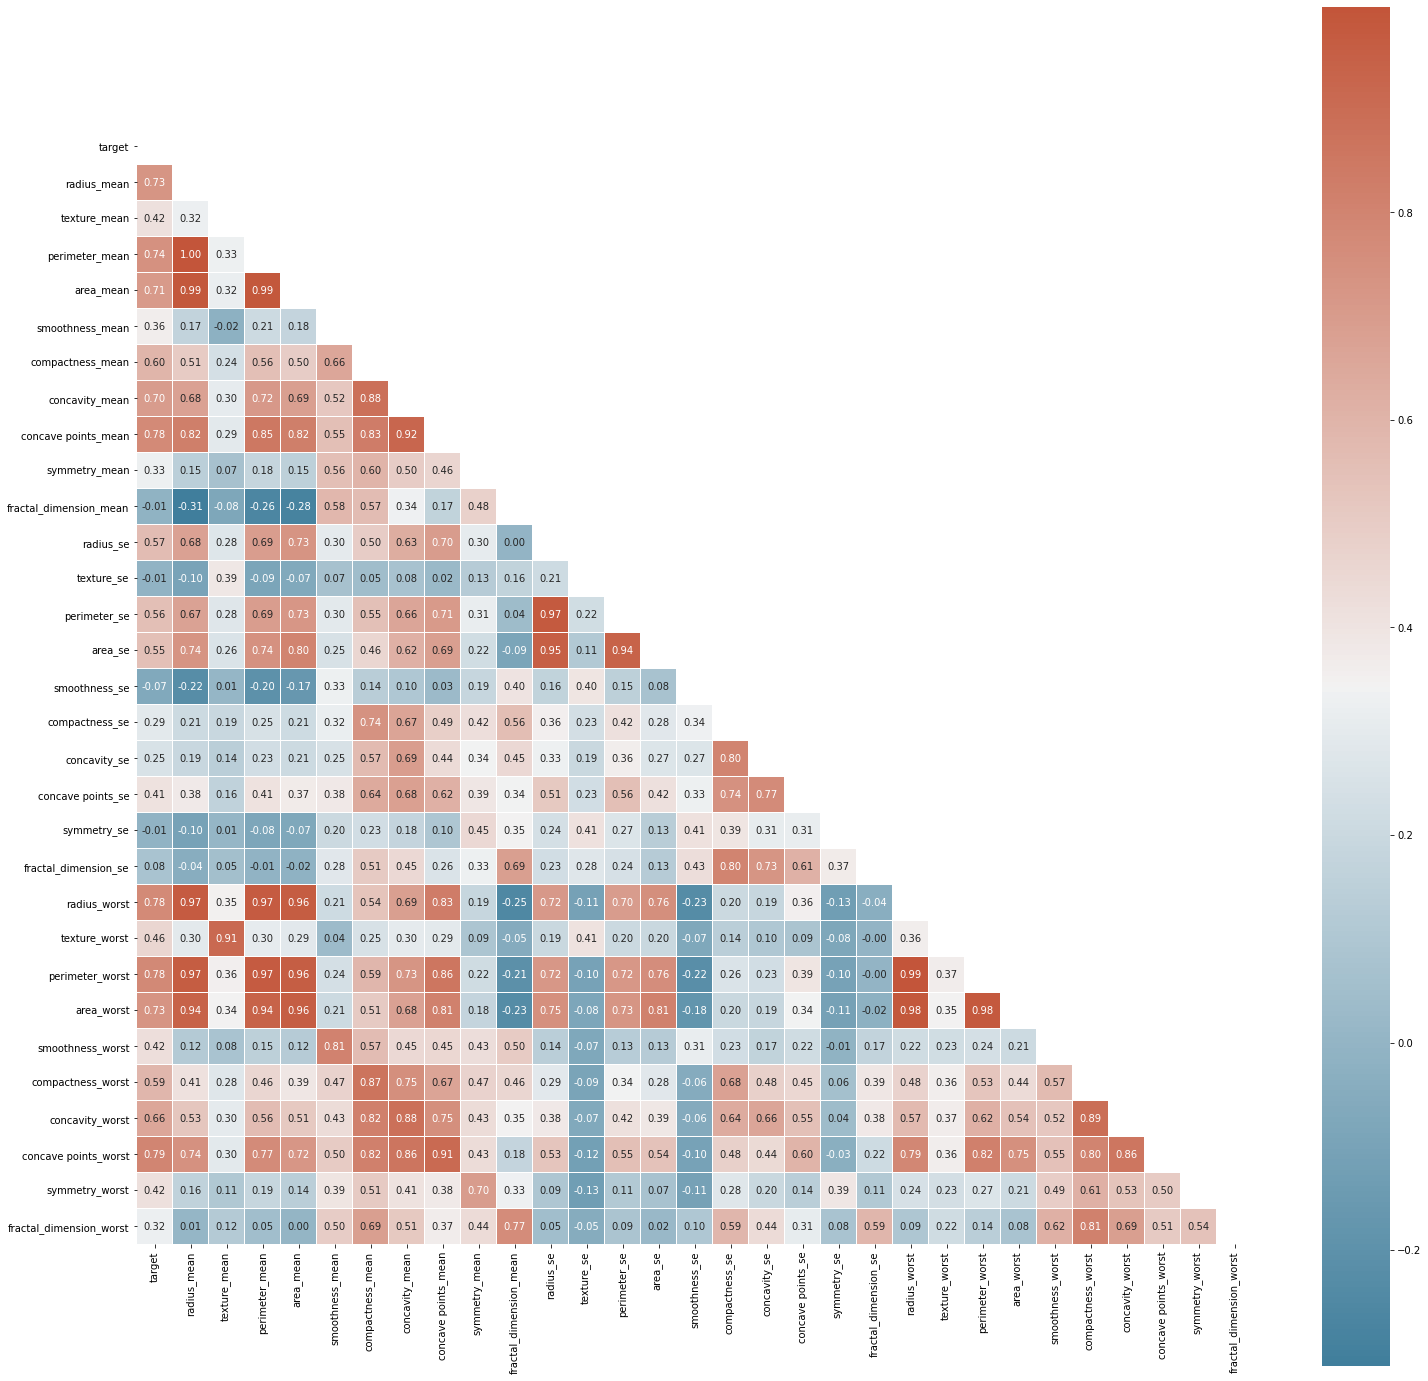

In [ ]:
correlation_matrix = data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(25, 25));
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True);
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, annot = True, fmt = ".2f",
            square=True, linewidths=.5);

# Plots

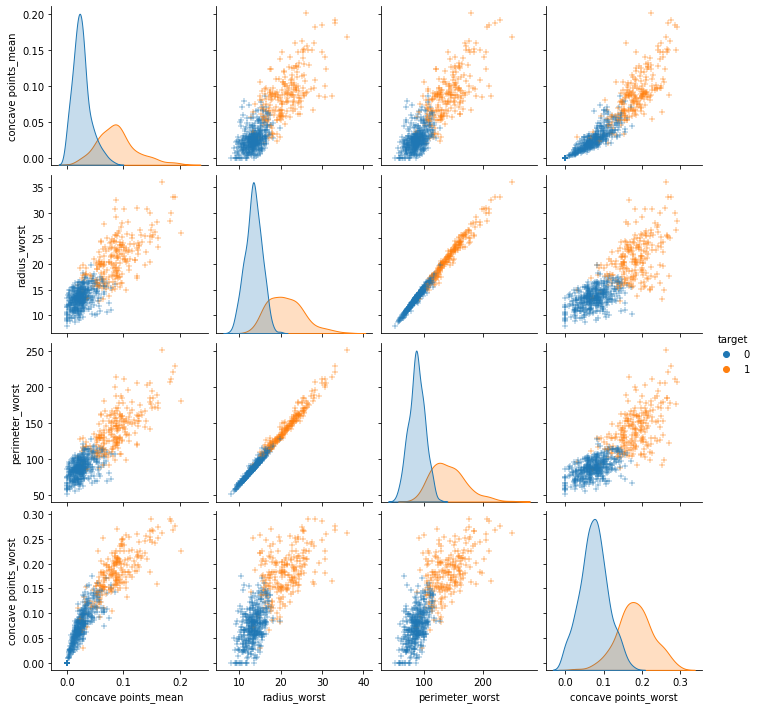

In [ ]:
#pairplot, kde = kernel density estimation
#%% Observing variables that are at least 75% related to the Target Feature
threshold = 0.75
filt = np.abs(correlation_matrix["target"]) > threshold
corr_features = correlation_matrix.columns[filt].tolist()
sns.pairplot(data[corr_features], diag_kind = "kde", markers = "+", hue ="target")
plt.show()

# Outliers

In [ ]:
#%% Outlier
outlier_threshold = -2
y = data.target
x = data.drop(["target"], axis = 1)
columns = x.columns.tolist()

clf = LocalOutlierFactor()
#-1 = outlier 1 = inlier
outlier_predict = clf.fit_predict(x)
feature_score = clf.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = feature_score

filter_outlier = outlier_score["score"] < outlier_threshold
outliers_index = outlier_score[filter_outlier].index.tolist()
#drop outliers
x = x.drop(outliers_index)
y = y.drop(outliers_index).values

# Train-Test Split and Standardization

In [ ]:
# random state = the result of mixing is the same every time.
x_train, x_test, y_train, y_test = train_test_split(x, y ,test_size = 0.3, random_state=42, stratify=y)

# (x - mean) / std
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train_df = pd.DataFrame(x_train, columns = columns)
x_train_df_describe = x_train_df.describe()
x_train_df["target"] = y_train

# Confusion Matrix Plot Function


In [ ]:
def plotConfusionMatrix(conf_matrix):
  group_names = ["True Negative","False Positive","False Negative","True Positive"]
  group_counts = ["{0:0.0f}".format(value) for value in
                  conf_matrix.flatten()]
  labels = [f"{v1}\n{v2}" for v1, v2 in
            zip(group_names,group_counts)]
  labels = np.asarray(labels).reshape(2,2)
  ax= plt.subplot()
  sns.heatmap(conf_matrix, annot=labels,cmap='Blues', fmt="", linewidths=.5, ax = ax)
  ax.set_xlabel('Predicted labels');
  ax.set_ylabel('True labels'); 
  plt.show()
  print("\n\n")

# KNN

Test Score: 0.9647058823529412, Train Score: 0.9796954314720813



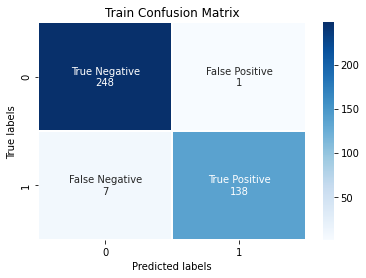

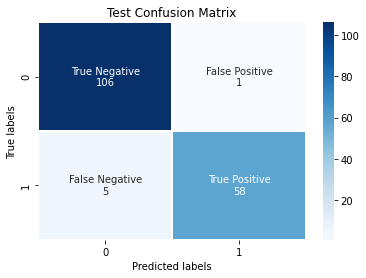

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(x_train, y_train)

y_pred_tr = knn.predict(x_train)
y_pred = knn.predict(x_test)

confusionMatrixTrain = confusion_matrix(y_train, y_pred_tr)
confusionMatrix_test = confusion_matrix(y_test, y_pred)

acc_tr = accuracy_score(y_train, y_pred_tr)
acc_test = accuracy_score(y_test, y_pred)

print("Test Score: {}, Train Score: {}\n".format(acc_test, acc_tr))

plt.title("Train Confusion Matrix")
plotConfusionMatrix(confusionMatrixTrain)

plt.title("Test Confusion Matrix")
plotConfusionMatrix(confusionMatrix_test)

# Knn Tuned

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    1.6s finished


Best training score: 0.9678812590929236 with parameters: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Test Score: 0.9529411764705882, Train Score: 0.9949238578680203



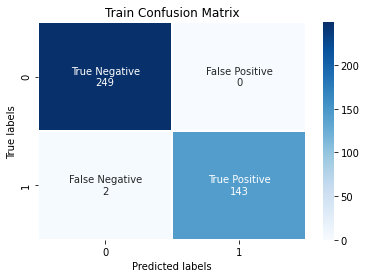

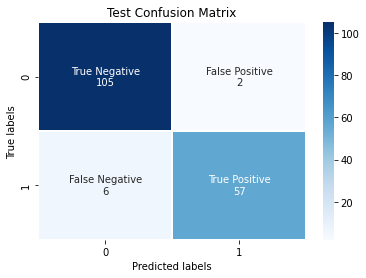

In [ ]:
def knn_tune(x_train, x_test, y_train, y_test):
    k_range = list(range(3,31,2))
    weight_options = ["uniform", "distance"]
    distance = [1,2]
    param_grid = dict(n_neighbors = k_range, weights = weight_options, p = distance)
    
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv = StratifiedKFold(n_splits=5, random_state=42), scoring = "f1", verbose = 1)
    grid.fit(x_train, y_train)
    print("Best training score: {} with parameters: {}".format(grid.best_score_, grid.best_params_))
    knn = KNeighborsClassifier(**grid.best_params_)
    knn.fit(x_train, y_train)
    
    y_pred_test = knn.predict(x_test)
    y_pred_train = knn.predict(x_train)
    
    confusionMatrixTest = confusion_matrix(y_test, y_pred_test)
    confusionMatrixTrain = confusion_matrix(y_train, y_pred_train)

    accTest = accuracy_score(y_test, y_pred_test)
    accTrain = accuracy_score(y_train, y_pred_train)
    
    print("Test Score: {}, Train Score: {}\n".format(accTest, accTrain))
    plt.title("Train Confusion Matrix")
    plotConfusionMatrix(confusionMatrixTrain)
    plt.title("Test Confusion Matrix")
    plotConfusionMatrix(confusionMatrixTest)
    
    return grid

grid = knn_tune(x_train, x_test, y_train, y_test)

# Scaled data

In [ ]:
x_scaled = scaler.fit_transform(x)

# PCA

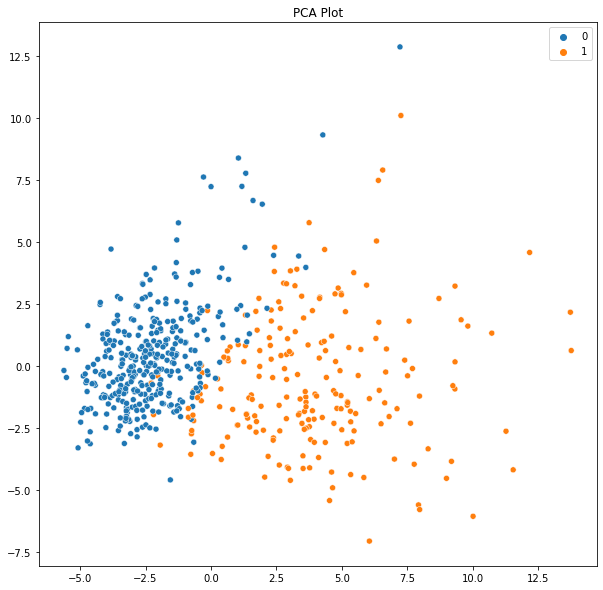

In [ ]:
#PCA can give values like 3-4. The variance described will be increased.
pca = PCA(n_components = 2)
pca.fit(x_scaled)
x_reduced_features = pca.transform(x_scaled)
#x = p1, y = p2, hue = target feature, The 2 variables with the highest variance are plotted.
plt.subplots(figsize=(10, 10))
sns.scatterplot(x = x_reduced_features[:,0], y = x_reduced_features[:,1], hue = y)
plt.title("PCA Plot");

In [ ]:
#variance ratio explained by the variables
print(pca.explained_variance_ratio_)
#sum of variance ratio explained by the variables
print(sum(pca.explained_variance_ratio_))

[0.45219371 0.18825055]
0.6404442608193791


Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    1.1s finished


Best training score: 0.9242105263157896 with parameters: {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
Test Score: 0.9529411764705882, Train Score: 0.9517766497461929



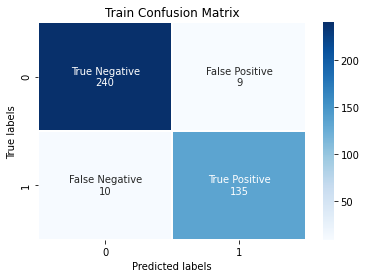

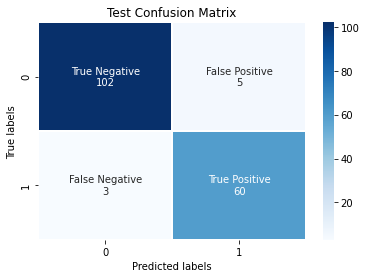

In [ ]:
#pca train an prediction
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_reduced_features, y ,test_size = 0.3, random_state=42, stratify=y)
grid_pca = knn_tune(x_train_pca, x_test_pca, y_train_pca, y_test_pca)

# NCA

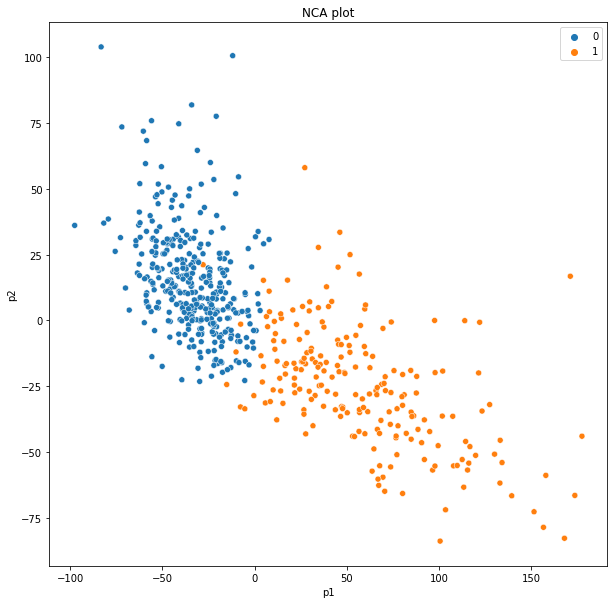

In [ ]:
nca = NeighborhoodComponentsAnalysis(n_components = 2, random_state = 42)
x_reduced_nca = nca.fit(x_scaled,y).transform(x_scaled)
nca_data = pd.DataFrame(x_reduced_nca, columns = ["p1", "p2"])
nca_data["target"] = y
plt.subplots(figsize=(10, 10))
sns.scatterplot(x = nca_data[:]["p1"], y = nca_data[:]["p2"], hue = y)
plt.title("NCA plot");

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best training score: 0.9928571428571429 with parameters: {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Test Score: 0.9823529411764705, Train Score: 1.0



[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    1.0s finished


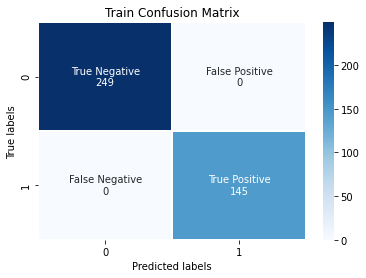

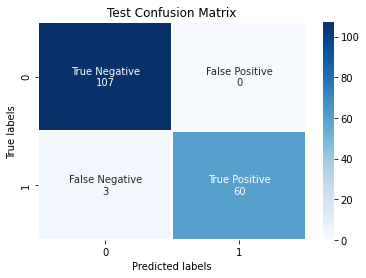

In [ ]:
x_train_nca, x_test_nca, y_train_nca, y_test_nca = train_test_split(x_reduced_nca, y ,test_size = 0.3, random_state=42, stratify=y)
grid_nca = knn_tune(x_train_nca, x_test_nca, y_train_nca, y_test_nca)